# Project Name: NNN_FINAL
## Dataset Information
- **Dataset Name:** [Mall Dataset crowd counting dataset]
- **Provider:** [The dataset was collected by C. C. Loy, S. Gong, T. Xiang, and K. Chen as part of their research for crowd counting and profiling.]
- **License:** [Research purposes only, non-commercial use.]
- **Dataset Link:** [https://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html]
- **Purpose:** Used for [This dataset is used for training a crowd counting object detection model as part of a mini-project, focusing on analyzing pedestrian density and zone-wise distribution.].

**Provider**: Based on the dataset description, the primary researchers/authors who created and annotated the dataset are listed as the providers. They collected the data from a publicly accessible webcam for their research.
"Collected by C. C. Loy, S. Gong, T. Xiang, and K. Chen."
License: The dataset description explicitly mentions:

"The dataset is intended for research purposes only and as such cannot be used commercially."
Therefore, the license type can be summarized as Research-only, non-commercial use.

**Purpose**: Since our Project involves object detection and crowd counting, this can be described as:

"This dataset is used to train an object detection model to count and analyze pedestrians for zone-wise distribution in a controlled research environment."

**Citations**

1. C. C. Loy, S. Gong, and T. Xiang, From Semi-Supervised to Transfer Counting of Crowds, Proceedings of IEEE International Conference on Computer Vision (ICCV), 2013.
2. K. Chen, S. Gong, T. Xiang, and C. C. Loy, Cumulative Attribute Space for Age and Crowd Density Estimation, IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2013.


##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");


In [26]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Importing the necessary libraries

In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import time
import tempfile

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model


from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
from PIL import ImageFont

from sklearn.model_selection import train_test_split
from six import BytesIO
from six.moves.urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 12.6 s, sys: 418 ms, total: 13 s
Wall time: 18.3 s


In [ ]:

I = plt.imread('/content/drive/MyDrive/Dataset/Mall_Dataset/frames/seq_000001.jpg')
I.shape

(480, 640, 3)

In [ ]:
I[120,600]

array([139, 121, 109], dtype=uint8)

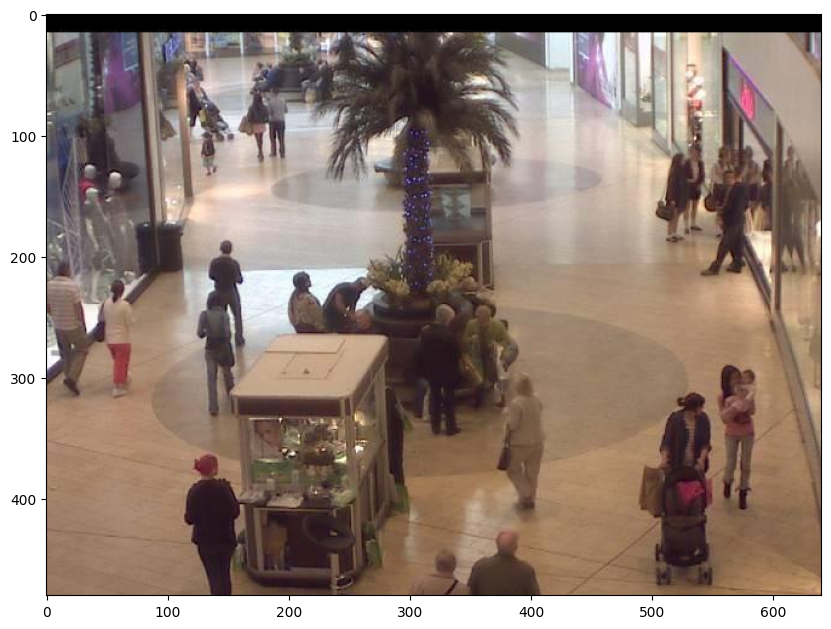

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(I)

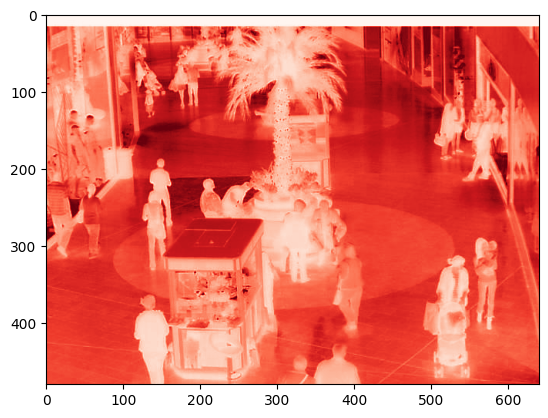

In [ ]:
plt.imshow(I[:,:,0], cmap='Reds')

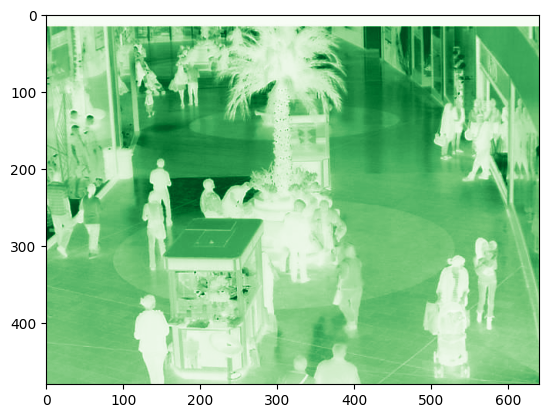

In [ ]:
plt.imshow(I[:,:,1], cmap='Greens')

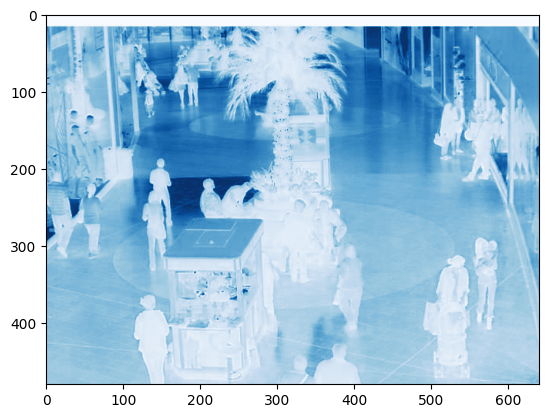

In [ ]:
plt.imshow(I[:,:,2], cmap='Blues')

In [ ]:
BW= np.mean(I, axis=2)
BW.shape

(480, 640)

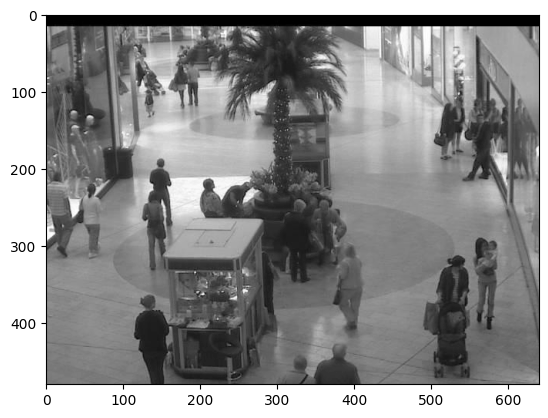

In [ ]:
plt.imshow(BW, cmap='gray')

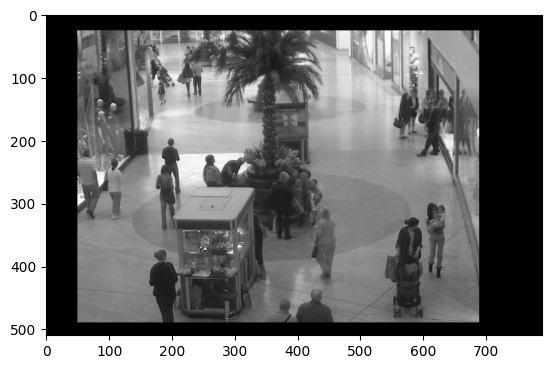

In [ ]:
PaddedImage = np.pad(BW,((10,20),(50,100)), 'constant')
plt.imshow(PaddedImage, cmap='gray')

# The Convolution Block
## Discrete 2D Convolution

In [ ]:
def discrete2DConvolution(Image, filter, padding):
  paddedImage=np.pad(Image, padding,'constant')
  flter = np.rot90(filter,2)
  conv =np.empty(Image.shape)
  #Striding and Multiplying
  for i in range(paddedImage.shape[0]-flter.shape[0]):
    for j in range(paddedImage.shape[1]-flter.shape[1]):
      conv[i,j]= np.sum((paddedImage[i:i+flter.shape[0],j:j+flter.shape[1]])*flter)

  return conv


In [ ]:
flterREdge =  np.array(([[-10,0,10],[-10,0,10],[-10,0,10]]))
flterLEdge =  np.array(([[10,0,-10],[10,0,-10],[10,0,-10]]))

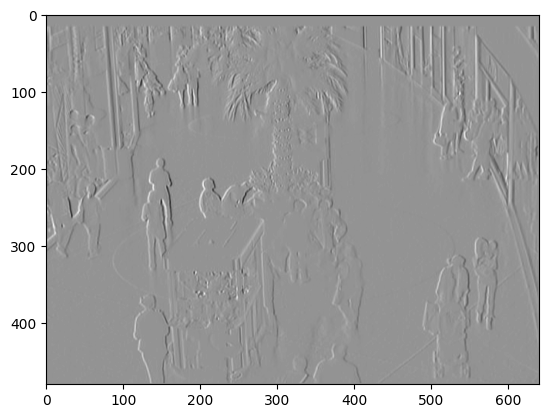

In [ ]:
ImConv = discrete2DConvolution(BW,flterREdge,1)
plt.imshow(ImConv, cmap='gray')

In [ ]:
def MaxPool(Image, ksize, stride):
  n=0
  k=0

  vert = int(Image.shape[1]/stride)
  hoz = int(Image.shape[0]/stride)
  MxPool = np.empty((hoz,vert))

  for i in range(0, Image.shape[0]-stride, stride):
    n = 0
    for j in range(0,Image.shape[1]-stride, stride):
      MxPool[k,n] = np.max(Image[i:i+ksize,j:j+ksize])
      n+=1
    k+=1

  return MxPool

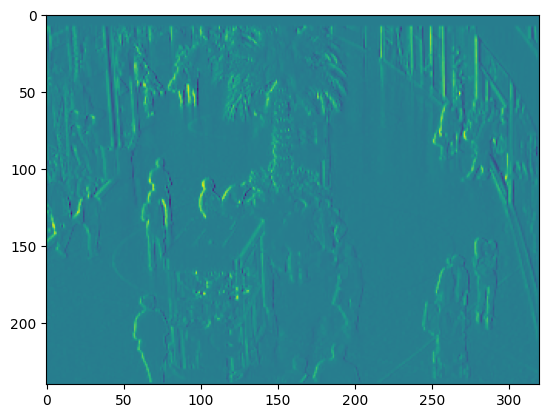

In [ ]:
ImPool=MaxPool(ImConv,2,2)
plt.imshow(ImPool)

# Plotting imgaes from the dataset

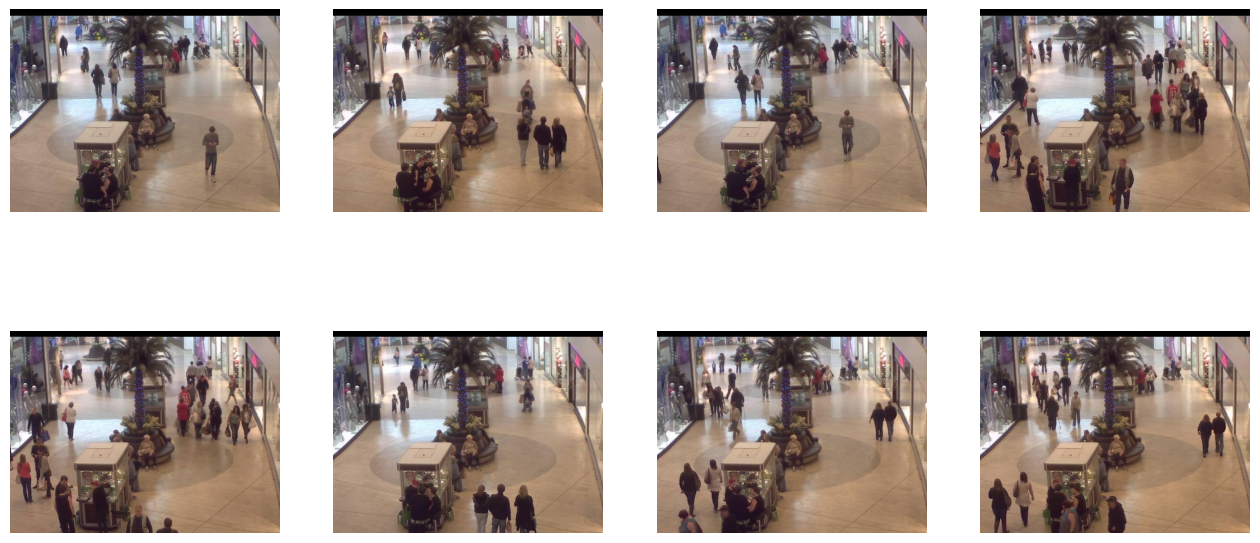

In [ ]:
nrows = 4
ncols = 4
pic_index = 0

mall_images_dir = '/content/drive/MyDrive/Dataset/Mall_Dataset/frames'
mall_image_fnames = os.listdir(mall_images_dir)
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index = 8
next_mall_images = [os.path.join(mall_images_dir, fname) for fname in mall_image_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_mall_images):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis("Off")
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# Object detection
## Extracting people count from the frames

In [ ]:
# Load object detection model from TensorFlow Hub (SSD MobileNet V2)

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
# module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
detector = hub.load(module_handle).signatures['default']

# Useful Functions

In [ ]:
# Function to load an image from the path
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

# Function to draw bounding boxes and count people in the image
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

    # Handle display strings and add them above or below the box.
    display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    text_bottom = top if top > total_display_str_height else top + total_display_str_height

    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)
        text_width, text_height = bbox[2], bbox[3]
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin

# Function to draw boxes and count people
def draw_boxes(image, boxes, class_names, scores, max_boxes=50, min_score=0.1):
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        font = ImageFont.load_default()

    people_count = 0
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score and class_names[i] == b'Person':  # Only count 'Person'
            people_count += 1
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "Person: {}%".format(int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))

    return image, people_count

# Function to display an image
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

# Function to run the detector and count people in the image
def run_detector(detector, img_path):
  img = load_img(img_path)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes, people_count = draw_boxes(img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])

  print(f"Total number of people detected: {people_count}")
  display_image(image_with_boxes)
  return image_with_boxes, people_count

In [ ]:
# Directory for  mall dataset
mall_images_dir = '/content/drive/MyDrive/Dataset/Mall_Dataset/frames'

# Showing how persons are been counted in images

Found 100 objects.
Inference time:  40.51781415939331
Total number of people detected: 27
CPU times: user 1min 35s, sys: 35.5 s, total: 2min 11s
Wall time: 40.9 s


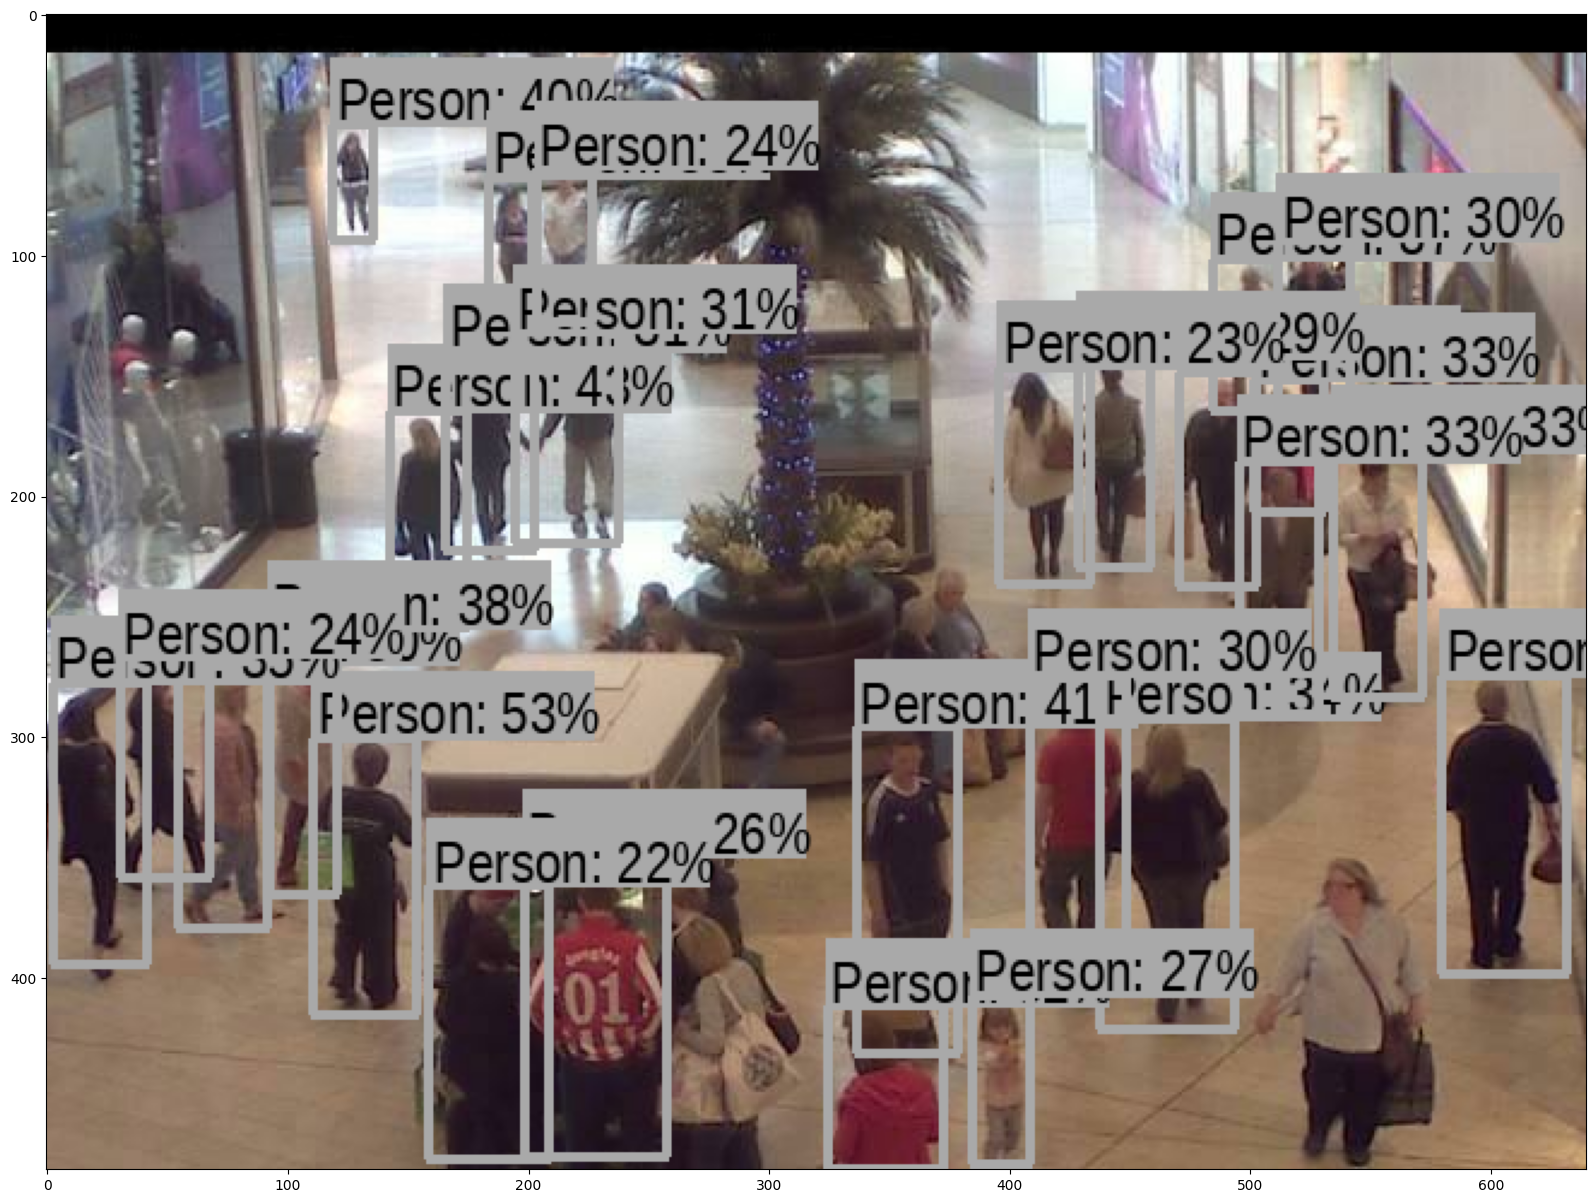

In [ ]:
%%time
test_image_filename = "/content/drive/MyDrive/Dataset/Mall_Dataset/frames/seq_000644.jpg"
image_path = test_image_filename

if os.path.exists(image_path):
    # Run the detector
    run_detector(detector, image_path)
else:
    print(f"Image {test_image_filename} not found in the directory.")

# Counting People Zone Wise for single image

In [ ]:
# Function to draw boxes and count people
def draw_boxes(image, boxes, class_names, scores, max_boxes=50, min_score=0.1):
    colors = list(ImageColor.colormap.values())
    people_count = 0
    detected_boxes = []

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score and class_names[i] == b'Person':  # Only count 'Person'
            people_count += 1
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "Person: {}%".format(int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            detected_boxes.append((ymin, xmin, ymax, xmax))

    return image, people_count, detected_boxes

# Function to count people within  zones
def count_people_in_zones(boxes, zones):
    zone_people_count = {i: 0 for i in range(len(zones))}
    for ymin, xmin, ymax, xmax in boxes:
        for i, zone in enumerate(zones):
            zone_ymin, zone_xmin, zone_ymax, zone_xmax = zone
            # Checking if the boxes are in the zone
            if (xmin >= zone_xmin and xmax <= zone_xmax and ymin >= zone_ymin and ymax <= zone_ymax):
                zone_people_count[i] += 1
    return zone_people_count

# Define image zones in to 4 quadrants
def define_zones(image_width, image_height, num_rows=2, num_cols=2):
    zone_width = image_width // num_cols
    zone_height = image_height // num_rows
    zones = []
    for row in range(num_rows):
        for col in range(num_cols):
            xmin = col * zone_width
            ymin = row * zone_height
            xmax = xmin + zone_width
            ymax = ymin + zone_height
            zones.append((ymin / image_height, xmin / image_width, ymax / image_height, xmax / image_width))
    return zones

# Function to display the image with bounding boxes and zone counts
def display_image_with_zones(image, detected_boxes, zone_people_count, zones, total_people_count):
    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    draw = ImageDraw.Draw(image_pil)
    image_width, image_height = image_pil.size

    # Draw zones on the image
    for i, zone in enumerate(zones):
        zone_ymin, zone_xmin, zone_ymax, zone_xmax = zone
        left = zone_xmin * image_width
        top = zone_ymin * image_height
        right = zone_xmax * image_width
        bottom = zone_ymax * image_height
        draw.rectangle([left, top, right, bottom], outline="blue", width=2)
        draw.text((left + 5, top + 5), f"Zone {i+1}: {zone_people_count[i]} people", fill="blue")

    # Draw total people count at the bottom of the image
    draw.text((10, image_height - 30), f"Total number of people detected: {total_people_count}", fill="black")

    # Display the result
    plt.imshow(image_pil)
    plt.axis("off")
    plt.show()

# Function to run the detector and analyze the image
def run_detector(detector, img_path, num_rows=2, num_cols=2):
    img = load_img(img_path)
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key: value.numpy() for key, value in result.items()}
    print(f"Found {len(result['detection_scores'])} objects.")
    print("Inference time: ", end_time - start_time)

    image_with_boxes, people_count, detected_boxes = draw_boxes(img.numpy(), result['detection_boxes'], result['detection_class_entities'], result['detection_scores'])

    # Get the zones
    zones = define_zones(image_with_boxes.shape[1], image_with_boxes.shape[0], num_rows, num_cols)
    zone_people_count = count_people_in_zones(detected_boxes, zones)

    # Display the image with zone information
    display_image_with_zones(image_with_boxes, detected_boxes, zone_people_count, zones, people_count)

    # Print zone-wise people count
    print(f"Total number of people detected: {people_count}")
    print("Zone-wise people count:")
    for i, count in zone_people_count.items():
        print(f"  Zone {i + 1}: {count} people")

    return image_with_boxes, people_count




Found 100 objects.
Inference time:  2.168574571609497


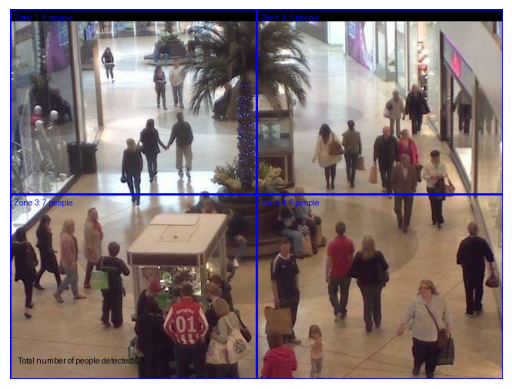

Total number of people detected: 27
Zone-wise people count:
  Zone 1: 5 people
  Zone 2: 6 people
  Zone 3: 7 people
  Zone 4: 6 people


In [ ]:
# Run the detector
test_image_filename = "/content/drive/MyDrive/Dataset/Mall_Dataset/frames/seq_000644.jpg"
if os.path.exists(test_image_filename):
    run_detector(detector, test_image_filename)
else:
    print(f"Image {test_image_filename} not found.")

# Counting people on the whole dataset from the images

In [ ]:
%%time
# Function to run the detector and analyze the image
def run_detector(detector, img_path, num_rows=2, num_cols=2):
    img = load_img(img_path)
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key: value.numpy() for key, value in result.items()}
    print(f"Found {len(result['detection_scores'])} objects.")
    print("Inference time: ", end_time - start_time)

    image_with_boxes, people_count, detected_boxes = draw_boxes(img.numpy(), result['detection_boxes'], result['detection_class_entities'], result['detection_scores'])

    # Get the zones
    zones = define_zones(image_with_boxes.shape[1], image_with_boxes.shape[0], num_rows, num_cols)
    zone_people_count = count_people_in_zones(detected_boxes, zones)

    return image_with_boxes, people_count, zone_people_count

# create a empty list for people count
people_count_data = []

# Directory for  mall dataset
mall_images_dir = '/content/drive/MyDrive/Dataset/Mall_Dataset/frames'

# Iterate over all images in the directory
for image_filename in os.listdir(mall_images_dir):
    if image_filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Filter image files
        image_path = os.path.join(mall_images_dir, image_filename)
        print(f"Running detection on: {image_path}")

        # Run detection and get people count and zone-wise count
        _, people_count, zone_people_count = run_detector(detector, image_path)

        print(f"Total number of people detected in {image_filename}: {people_count}")

        # Append the result to the list
        people_count_data.append({
            'image_filename': image_filename,
            'people_count': people_count,
            'zone_1': zone_people_count.get(0, 0),
            'zone_2': zone_people_count.get(1, 0),
            'zone_3': zone_people_count.get(2, 0),
            'zone_4': zone_people_count.get(3, 0)
        })

# Convert the data into a pandas DataFrame
df = pd.DataFrame(people_count_data)

# Save the DataFrame to a CSV file
output_csv = '/content/drive/MyDrive/Dataset/T4_people_mall_count_with_zones.csv'
df.to_csv(output_csv, index=False)

print(f"People count data saved to {output_csv}")


Streaming output truncated to the last 5000 lines.
Total number of people detected in seq_001734.jpg: 17
Running detection on: /content/drive/MyDrive/Dataset/Mall_Dataset/frames/seq_001728.jpg
Found 100 objects.
Inference time:  2.1836209297180176
Total number of people detected in seq_001728.jpg: 23
Running detection on: /content/drive/MyDrive/Dataset/Mall_Dataset/frames/seq_001741.jpg
Found 100 objects.
Inference time:  2.140080451965332
Total number of people detected in seq_001741.jpg: 20
Running detection on: /content/drive/MyDrive/Dataset/Mall_Dataset/frames/seq_001745.jpg
Found 100 objects.
Inference time:  2.242816209793091
Total number of people detected in seq_001745.jpg: 25
Running detection on: /content/drive/MyDrive/Dataset/Mall_Dataset/frames/seq_001739.jpg
Found 100 objects.
Inference time:  2.2664451599121094
Total number of people detected in seq_001739.jpg: 18
Running detection on: /content/drive/MyDrive/Dataset/Mall_Dataset/frames/seq_001743.jpg
Found 100 objects.
In

**Hand Over to Team Leader**

# Save the results

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/T4_people_mall_count_with_zones.csv')
df


image_filename  people_count  zone_1  zone_2  zone_3  zone_4
0     seq_001012.jpg            17       6       5       3       1
1     seq_001021.jpg            25       6       6       6       3
2     seq_001011.jpg            18       6       6       3       0
3     seq_000993.jpg            23       4       6       6       0
4     seq_000994.jpg            29       6       7       6       1
...              ...           ...     ...     ...     ...     ...
1995  seq_001016.jpg            22       9       7       4       0
1996  seq_001000.jpg            25       7       3       2       4
1997  seq_000996.jpg            25       9       8       4       2
1998  seq_000992.jpg            22       5       7       4       0
1999  seq_001003.jpg            21       6       3       4       4

[2000 rows x 6 columns]

In [4]:
df.columns

Index(['image_filename', 'people_count', 'zone_1', 'zone_2', 'zone_3',
       'zone_4'],
      dtype='object')

In [5]:
df.head()

image_filename  people_count  zone_1  zone_2  zone_3  zone_4
0  seq_001012.jpg            17       6       5       3       1
1  seq_001021.jpg            25       6       6       6       3
2  seq_001011.jpg            18       6       6       3       0
3  seq_000993.jpg            23       4       6       6       0
4  seq_000994.jpg            29       6       7       6       1

In [6]:
# Calculating the rows * columns in the dataframe
print(df.shape)

(2000, 6)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filename  2000 non-null   object
 1   people_count    2000 non-null   int64 
 2   zone_1          2000 non-null   int64 
 3   zone_2          2000 non-null   int64 
 4   zone_3          2000 non-null   int64 
 5   zone_4          2000 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 93.9+ KB


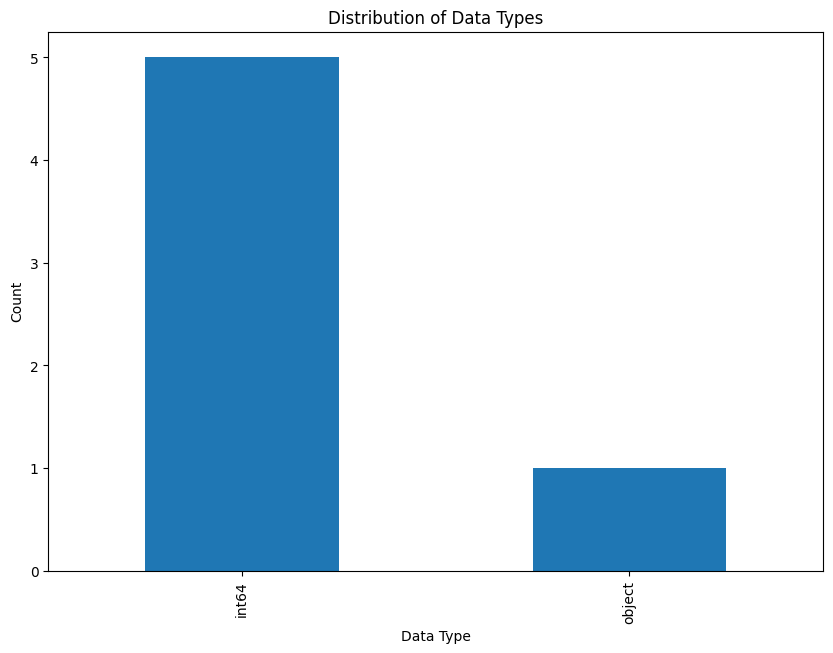

In [8]:
plt.figure(figsize=(10,7))
df.dtypes.value_counts().plot(kind='bar')
plt.title('Distribution of Data Types')
plt.xlabel('Data Type')
plt.ylabel('Count')
plt.show()

In [9]:
missing_values = df.isnull().sum()
missing_values


image_filename    0
people_count      0
zone_1            0
zone_2            0
zone_3            0
zone_4            0
dtype: int64

In [10]:
df.describe()

people_count       zone_1       zone_2       zone_3      zone_4
count   2000.000000  2000.000000  2000.000000  2000.000000  2000.00000
mean      19.915000     5.978000     3.755500     3.067500     2.08500
std        3.468255     2.459581     2.223104     1.708919     1.75023
min        6.000000     0.000000     0.000000     0.000000     0.00000
25%       18.000000     4.000000     2.000000     2.000000     1.00000
50%       20.000000     6.000000     4.000000     3.000000     2.00000
75%       22.000000     8.000000     5.000000     4.000000     3.00000
max       30.000000    16.000000    12.000000    11.000000     8.00000

# Data Visualisation

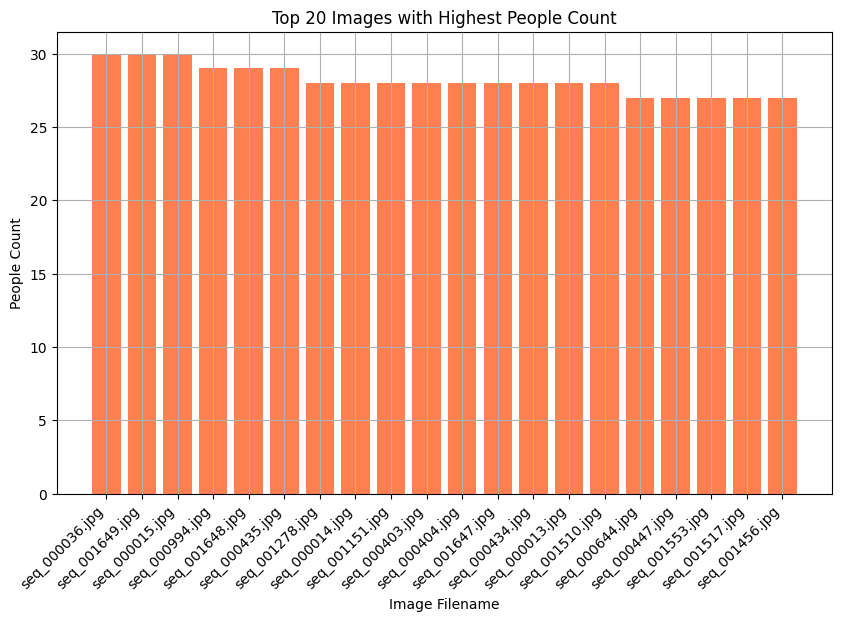

In [97]:
# Get the top 20 images by people count
top_images = df.sort_values('people_count', ascending=False).head(20)

# Bar plot for the top images
plt.figure(figsize=(10, 6))
plt.bar(top_images['image_filename'], top_images['people_count'], color='coral')
plt.title('Top 20 Images with Highest People Count')
plt.xlabel('Image Filename')
plt.ylabel('People Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

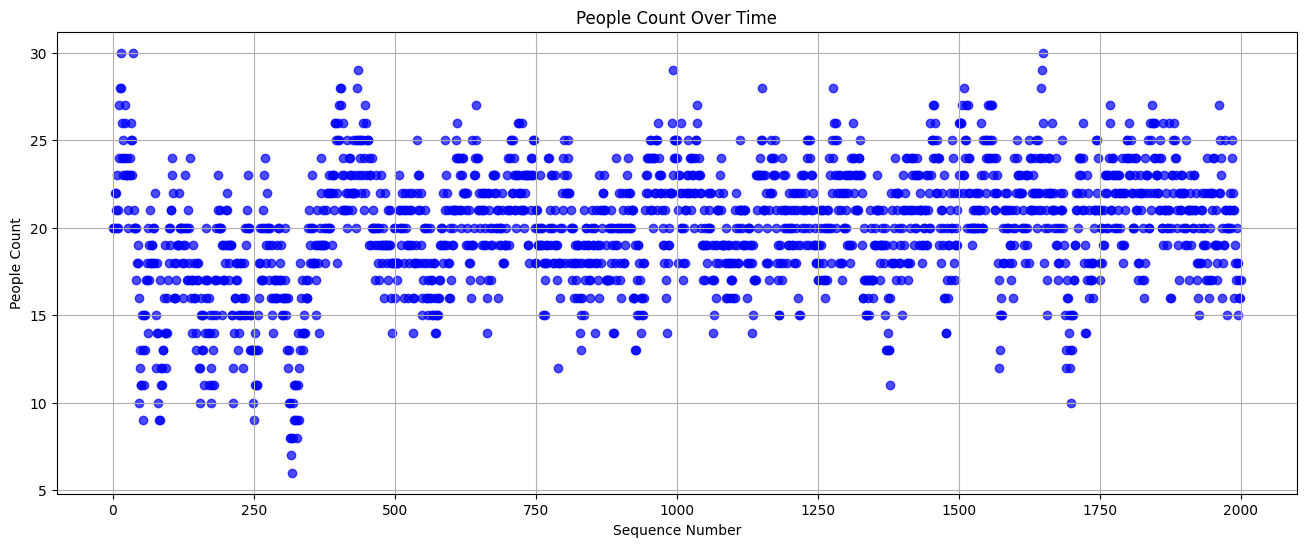

In [98]:
# Extract sequence number from the image filename
df['sequence_number'] = df['image_filename'].apply(lambda x: int(x.split('_')[1].split('.')[0]))

# Sort the DataFrame by sequence number
df_sorted = df.sort_values(by='sequence_number')

# Scatter plot for people count over time (sequence number)
plt.figure(figsize=(16, 6))
plt.scatter(df_sorted['sequence_number'], df_sorted['people_count'], color='blue', alpha=0.7)
plt.title('People Count Over Time')
plt.xlabel('Sequence Number')
plt.ylabel('People Count')
plt.grid(True)
plt.show()

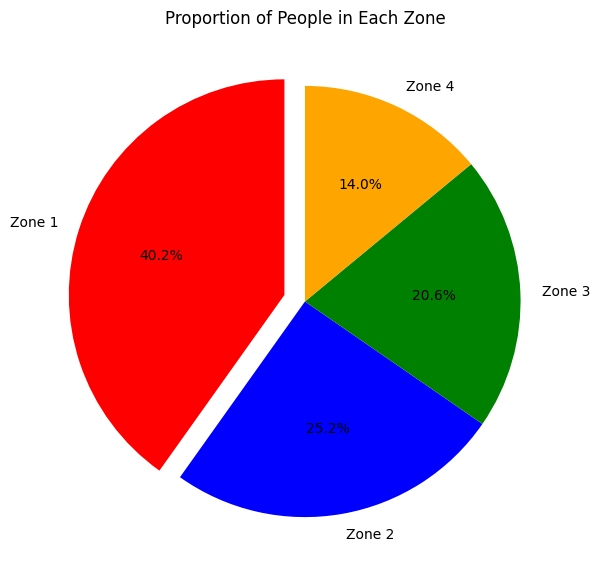

In [103]:
# Pie Chart - People in each zone in Percentages
import matplotlib.pyplot as plt

# Sum the people count in each zone across all rows
zone_totals = df[['zone_1', 'zone_2', 'zone_3', 'zone_4']].sum()

# Plot the pie chart
plt.figure(figsize=(7, 7))
zone_totals.plot.pie(
    autopct='%1.1f%%',  # Display percentage with one decimal place
    labels=['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4'],  # Label for each zone
    colors=['red', 'blue', 'green', 'orange'],  # Colors for each zone
    startangle=90,  # Start angle for the first slice
    explode=(0.1, 0, 0, 0),  # Explode the first slice (Zone 1) for emphasis
)

# Title for the pie chart
plt.title('Proportion of People in Each Zone')

# Show the plot
plt.show()


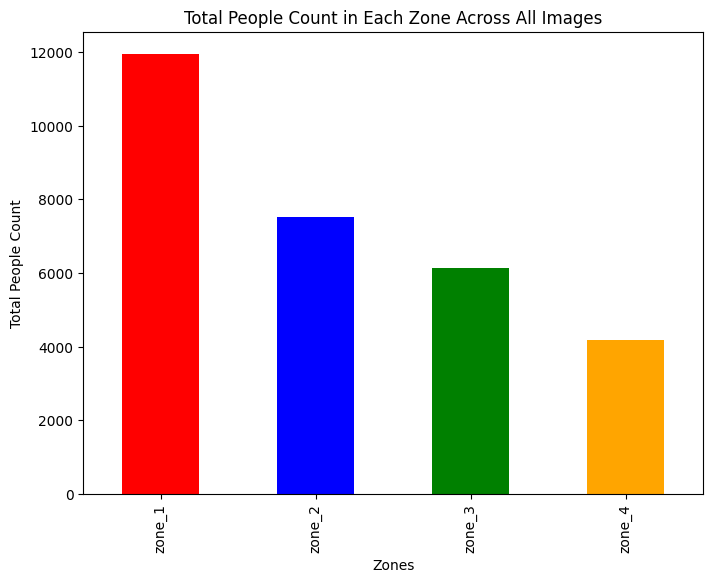

In [104]:
# Zone Comparision Bar chart
import matplotlib.pyplot as plt

# Sum the people count in each zone across all rows
zone_totals = df[['zone_1', 'zone_2', 'zone_3', 'zone_4']].sum()

# the bar chart
plt.figure(figsize=(8, 6))
zone_totals.plot(kind='bar', color=['red', 'blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Zones')
plt.ylabel('Total People Count')
plt.title('Total People Count in Each Zone Across All Images')

# Display the plot
plt.show()


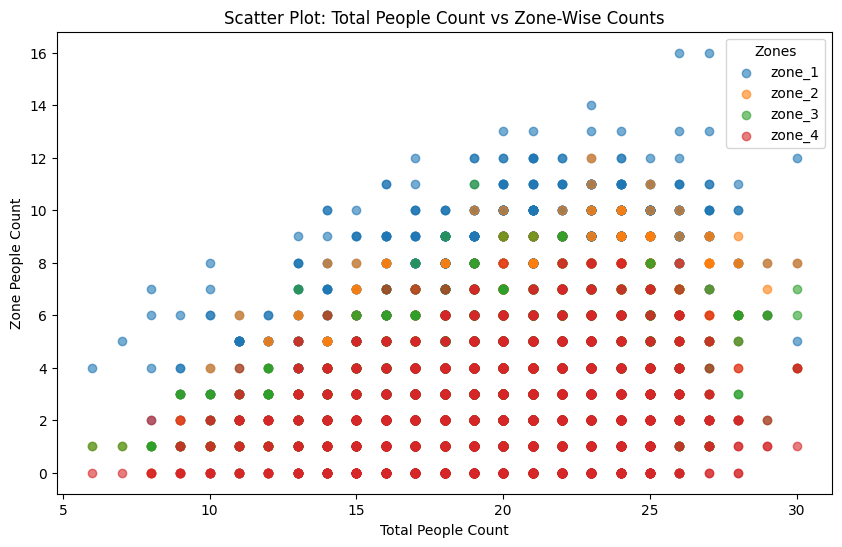

In [105]:
import matplotlib.pyplot as plt

# Create a figure for the scatter plot
plt.figure(figsize=(10, 6))

# Plot scatter points for each zone against the total people count
for zone in ['zone_1', 'zone_2', 'zone_3', 'zone_4']:
    plt.scatter(df['people_count'], df[zone], label=zone, alpha=0.6)

# Add labels and title
plt.xlabel('Total People Count')
plt.ylabel('Zone People Count')
plt.title('Scatter Plot: Total People Count vs Zone-Wise Counts')

# Add a legend to differentiate the zones
plt.legend(title='Zones')

# Display the plot
plt.show()



**HAND OVER TO TIME SERIES ANALYST**

# Time Series Analysis

In [ ]:
t_df = pd.read_csv('/content/drive/MyDrive/Dataset/T4_people_mall_count_with_zones.csv')

In [ ]:
# Display the  DataFrame
print(t_df.head())

   image_filename  people_count  zone_1  zone_2  zone_3  zone_4
0  seq_001012.jpg            17       6       5       3       1
1  seq_001021.jpg            25       6       6       6       3
2  seq_001011.jpg            18       6       6       3       0
3  seq_000993.jpg            23       4       6       6       0
4  seq_000994.jpg            29       6       7       6       1


In [ ]:
# Starting timestamp and interval
start_date = '2024-01-01 08:00:00'  # Mall opens at 8 AM and closes at 11 PM
time_interval = '30T'  # 30-minute intervals

# Generate timestamps based on the number of rows in the DataFrame
time_range = pd.date_range(start=start_date, periods=len(t_df), freq=time_interval)

# Filter timestamps to only include times from 8:00 AM to 11:00 PM
valid_time_range = time_range[(time_range.time >= pd.Timestamp('08:00:00').time()) &
                              (time_range.time <= pd.Timestamp('23:00:00').time())]

# Ensure that the filtered range matches the dataset length
valid_time_range = valid_time_range[:len(t_df)]

# Add timestamps to the existing DataFrame
t_df['timestamp'] = time_range

# Set timestamp as the index
t_df = t_df.set_index('timestamp')

# Split 'timestamp' into separate date and time columns
t_df['date'] = t_df.index.date
t_df['time'] = t_df.index.time

# print the dataframe
print(t_df.head())

# Verify the time range and duration
print(f"Data starts from: {t_df.index.min()}")
print(f"Data ends on: {t_df.index.max()}")



                     image_filename  people_count  zone_1  zone_2  zone_3  \
timestamp                                                                   
2024-01-01 08:00:00  seq_001012.jpg            17       6       5       3   
2024-01-01 08:30:00  seq_001021.jpg            25       6       6       6   
2024-01-01 09:00:00  seq_001011.jpg            18       6       6       3   
2024-01-01 09:30:00  seq_000993.jpg            23       4       6       6   
2024-01-01 10:00:00  seq_000994.jpg            29       6       7       6   

                     zone_4        date      time  
timestamp                                          
2024-01-01 08:00:00       1  2024-01-01  08:00:00  
2024-01-01 08:30:00       3  2024-01-01  08:30:00  
2024-01-01 09:00:00       0  2024-01-01  09:00:00  
2024-01-01 09:30:00       0  2024-01-01  09:30:00  
2024-01-01 10:00:00       1  2024-01-01  10:00:00  
Data starts from: 2024-01-01 08:00:00
Data ends on: 2024-02-11 23:30:00


<ipython-input-239-2241f8d698aa>:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start=start_date, periods=len(t_df), freq=time_interval)


In [ ]:
t_df

image_filename  people_count  zone_1  zone_2  zone_3  \
timestamp                                                                   
2024-01-01 08:00:00  seq_001012.jpg            17       6       5       3   
2024-01-01 08:30:00  seq_001021.jpg            25       6       6       6   
2024-01-01 09:00:00  seq_001011.jpg            18       6       6       3   
2024-01-01 09:30:00  seq_000993.jpg            23       4       6       6   
2024-01-01 10:00:00  seq_000994.jpg            29       6       7       6   
...                             ...           ...     ...     ...     ...   
2024-02-11 21:30:00  seq_001016.jpg            22       9       7       4   
2024-02-11 22:00:00  seq_001000.jpg            25       7       3       2   
2024-02-11 22:30:00  seq_000996.jpg            25       9       8       4   
2024-02-11 23:00:00  seq_000992.jpg            22       5       7       4   
2024-02-11 23:30:00  seq_001003.jpg            21       6       3       4   

                     zone_4        date      time  
timestamp                                          
2024-01-01 08:00:00       1  2024-01-01  08:00:00  
2024-01-01 08:30:00       3  2024-01-01  08:30:00  
2024-01-01 09:00:00       0  2024-01-01  09:00:00  
2024-01-01 09:30:00       0  2024-01-01  09:30:00  
2024-01-01 10:00:00       1  2024-01-01  10:00:00  
...                     ...         ...       ...  
2024-02-11 21:30:00       0  2024-02-11  21:30:00  
2024-02-11 22:00:00       4  2024-02-11  22:00:00  
2024-02-11 22:30:00       2  2024-02-11  22:30:00  
2024-02-11 23:00:00       0  2024-02-11  23:00:00  
2024-02-11 23:30:00       4  2024-02-11  23:30:00  

[2000 rows x 8 columns]

In [ ]:
t_df.columns

Index(['image_filename', 'people_count', 'zone_1', 'zone_2', 'zone_3',
       'zone_4', 'date', 'time'],
      dtype='object')

In [ ]:
# Make sure that both 'date' and 'time' are strings
t_df['date'] = t_df['date'].astype(str)
t_df['time'] = t_df['time'].astype(str)


# strip the 'timestamp' column for the date and time
t_df['timestamp'] = pd.to_datetime(t_df['date'] + ' ' + t_df['time'])

# Now, we extract the relevant time periods
# Extract month, week, day, and hour from the timestamp
t_df['month'] = t_df['timestamp'].dt.to_period('M')  # Year-Month
t_df['week'] = t_df['timestamp'].dt.to_period('W')  # Year-Week
t_df['day'] = t_df['timestamp'].dt.date  # Date (Year-Month-Day)
t_df['hour'] = t_df['timestamp'].dt.hour  # Hour of the day (0-23)



In [ ]:
# Summaries of the time period

# Monthly summary
monthly_summary = t_df.groupby('month')['people_count'].sum()

# Weekly summary
weekly_summary = t_df.groupby('week')['people_count'].sum()

# Daily summary
daily_summary = t_df.groupby('day')['people_count'].sum()

# Hourly summary
hourly_summary = t_df.groupby('hour')['people_count'].sum()


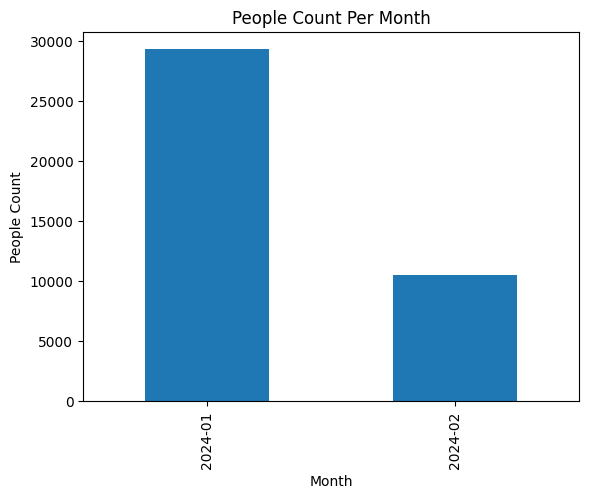

Monthly Summary:
month
2024-01    29327
2024-02    10503
Freq: M, Name: people_count, dtype: int64


In [ ]:
# Plot Monthly Summary
monthly_summary.plot(kind='bar', title="People Count Per Month")
plt.xlabel('Month')
plt.ylabel('People Count')
plt.show()
# Displaying the summaries
print("Monthly Summary:")
print(monthly_summary)


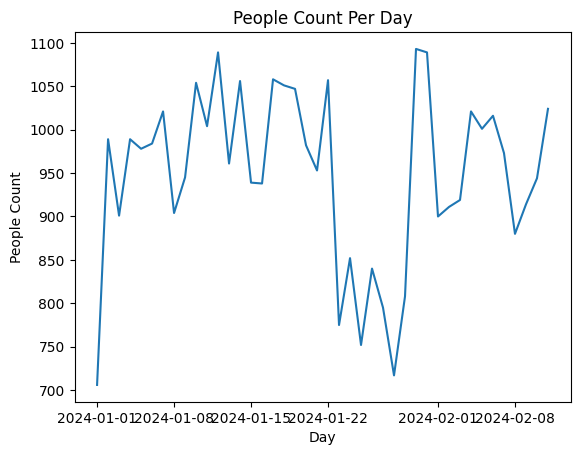


Daily Summary:
day
2024-01-01     706
2024-01-02     989
2024-01-03     901
2024-01-04     989
2024-01-05     978
2024-01-06     984
2024-01-07    1021
2024-01-08     904
2024-01-09     945
2024-01-10    1054
2024-01-11    1004
2024-01-12    1089
2024-01-13     961
2024-01-14    1056
2024-01-15     939
2024-01-16     938
2024-01-17    1058
2024-01-18    1051
2024-01-19    1047
2024-01-20     982
2024-01-21     953
2024-01-22    1057
2024-01-23     775
2024-01-24     852
2024-01-25     752
2024-01-26     840
2024-01-27     795
2024-01-28     717
2024-01-29     808
2024-01-30    1093
2024-01-31    1089
2024-02-01     900
2024-02-02     911
2024-02-03     919
2024-02-04    1021
2024-02-05    1001
2024-02-06    1016
2024-02-07     973
2024-02-08     880
2024-02-09     914
2024-02-10     944
2024-02-11    1024
Name: people_count, dtype: int64


In [ ]:
# Optionally, you can plot daily and weekly as well
daily_summary.plot(kind='line', title="People Count Per Day")
plt.xlabel('Day')
plt.ylabel('People Count')
plt.show()
print("\nDaily Summary:")
print(daily_summary)


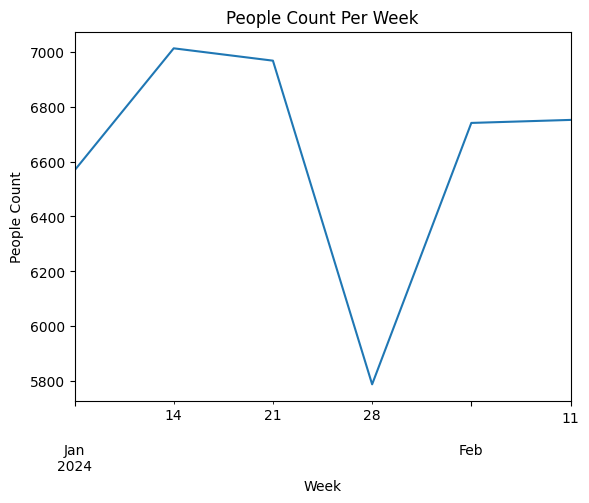


Weekly Summary:
week
2024-01-01/2024-01-07    6568
2024-01-08/2024-01-14    7013
2024-01-15/2024-01-21    6968
2024-01-22/2024-01-28    5788
2024-01-29/2024-02-04    6741
2024-02-05/2024-02-11    6752
Freq: W-SUN, Name: people_count, dtype: int64


In [ ]:
# Weekly
weekly_summary.plot(kind='line', title="People Count Per Week")
plt.xlabel('Week')
plt.ylabel('People Count')
plt.show()
print("\nWeekly Summary:")
print(weekly_summary)


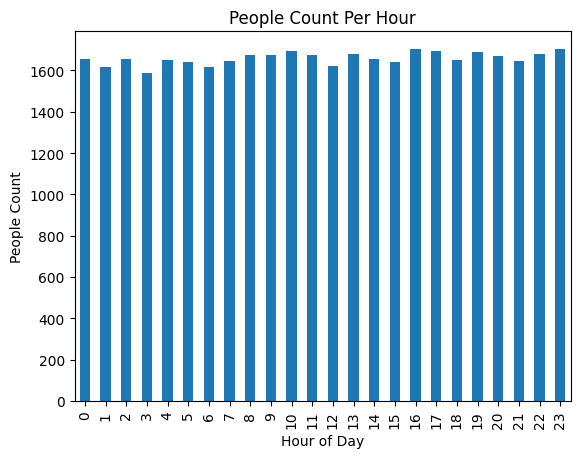


Hourly Summary:
hour
0     1657
1     1618
2     1654
3     1589
4     1651
5     1640
6     1619
7     1646
8     1677
9     1677
10    1694
11    1676
12    1623
13    1678
14    1656
15    1639
16    1704
17    1693
18    1649
19    1690
20    1671
21    1645
22    1680
23    1704
Name: people_count, dtype: int64


In [ ]:
# Plot Hourly Summary
hourly_summary.plot(kind='bar', title="People Count Per Hour")
plt.xlabel('Hour of Day')
plt.ylabel('People Count')
plt.show()
print("\nHourly Summary:")
print(hourly_summary)

In [ ]:
t_df

image_filename  people_count  zone_1  zone_2  zone_3  \
timestamp                                                                   
2024-01-01 08:00:00  seq_001012.jpg            17       6       5       3   
2024-01-01 08:30:00  seq_001021.jpg            25       6       6       6   
2024-01-01 09:00:00  seq_001011.jpg            18       6       6       3   
2024-01-01 09:30:00  seq_000993.jpg            23       4       6       6   
2024-01-01 10:00:00  seq_000994.jpg            29       6       7       6   
...                             ...           ...     ...     ...     ...   
2024-02-11 21:30:00  seq_001016.jpg            22       9       7       4   
2024-02-11 22:00:00  seq_001000.jpg            25       7       3       2   
2024-02-11 22:30:00  seq_000996.jpg            25       9       8       4   
2024-02-11 23:00:00  seq_000992.jpg            22       5       7       4   
2024-02-11 23:30:00  seq_001003.jpg            21       6       3       4   

                     zone_4        date      time           timestamp  \
timestamp                                                               
2024-01-01 08:00:00       1  2024-01-01  08:00:00 2024-01-01 08:00:00   
2024-01-01 08:30:00       3  2024-01-01  08:30:00 2024-01-01 08:30:00   
2024-01-01 09:00:00       0  2024-01-01  09:00:00 2024-01-01 09:00:00   
2024-01-01 09:30:00       0  2024-01-01  09:30:00 2024-01-01 09:30:00   
2024-01-01 10:00:00       1  2024-01-01  10:00:00 2024-01-01 10:00:00   
...                     ...         ...       ...                 ...   
2024-02-11 21:30:00       0  2024-02-11  21:30:00 2024-02-11 21:30:00   
2024-02-11 22:00:00       4  2024-02-11  22:00:00 2024-02-11 22:00:00   
2024-02-11 22:30:00       2  2024-02-11  22:30:00 2024-02-11 22:30:00   
2024-02-11 23:00:00       0  2024-02-11  23:00:00 2024-02-11 23:00:00   
2024-02-11 23:30:00       4  2024-02-11  23:30:00 2024-02-11 23:30:00   

                       month                   week         day  hour  
timestamp                                                              
2024-01-01 08:00:00  2024-01  2024-01-01/2024-01-07  2024-01-01     8  
2024-01-01 08:30:00  2024-01  2024-01-01/2024-01-07  2024-01-01     8  
2024-01-01 09:00:00  2024-01  2024-01-01/2024-01-07  2024-01-01     9  
2024-01-01 09:30:00  2024-01  2024-01-01/2024-01-07  2024-01-01     9  
2024-01-01 10:00:00  2024-01  2024-01-01/2024-01-07  2024-01-01    10  
...                      ...                    ...         ...   ...  
2024-02-11 21:30:00  2024-02  2024-02-05/2024-02-11  2024-02-11    21  
2024-02-11 22:00:00  2024-02  2024-02-05/2024-02-11  2024-02-11    22  
2024-02-11 22:30:00  2024-02  2024-02-05/2024-02-11  2024-02-11    22  
2024-02-11 23:00:00  2024-02  2024-02-05/2024-02-11  2024-02-11    23  
2024-02-11 23:30:00  2024-02  2024-02-05/2024-02-11  2024-02-11    23  

[2000 rows x 13 columns]

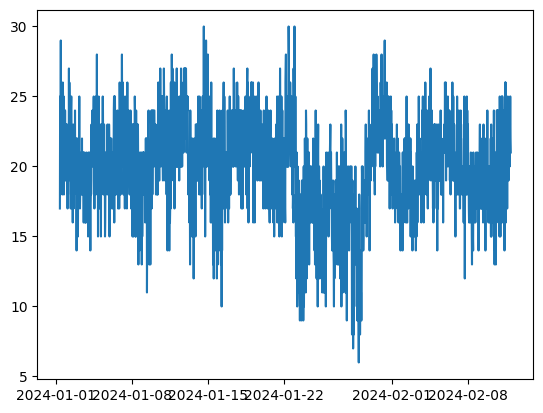

In [ ]:
plt.figure()
plt.plot(t_df.people_count)

In [ ]:
print(t_df.columns)

Index(['image_filename', 'people_count', 'zone_1', 'zone_2', 'zone_3',
       'zone_4', 'date', 'time', 'timestamp', 'month', 'week', 'day', 'hour'],
      dtype='object')


In [ ]:
def log_trans(t_df,people_count): return t_df[people_count].apply(lambda x:np.log(x))

In [ ]:
t_df['people_count_log'] = log_trans(t_df,'people_count')

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
def plot_decomposition(t_df, people_count, trend,seasonal, residual):
  f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,5), sharex=True )

  ax1.plot(t_df[people_count], label="Original")
  ax1.legend(loc='best')
  ax1.tick_params(axis ='x', rotation=45)

  ax2.plot(t_df[trend], label="Trend")
  ax2.legend(loc='best')
  ax2.tick_params(axis ='x', rotation=45)

  ax3.plot(t_df[seasonal], label="Seasonal")
  ax3.legend(loc='best')
  ax3.tick_params(axis ='x', rotation=45)

  ax4.plot(t_df[residual], label="Residuals")
  ax4.legend(loc='best')
  ax4.tick_params(axis ='x', rotation=45)

  plt.tight_layout()
  plt.show()

In [ ]:
new_df = t_df

In [ ]:
new_df.loc[:,'trend'] = decomposition.trend
new_df.loc[:,'seasonal'] = decomposition.seasonal
new_df.loc[:,'residuals'] = decomposition.resid

In [ ]:
new_df

image_filename  people_count  zone_1  zone_2  zone_3  \
timestamp                                                                   
2024-01-01 08:00:00  seq_001012.jpg            17       6       5       3   
2024-01-01 08:30:00  seq_001021.jpg            25       6       6       6   
2024-01-01 09:00:00  seq_001011.jpg            18       6       6       3   
2024-01-01 09:30:00  seq_000993.jpg            23       4       6       6   
2024-01-01 10:00:00  seq_000994.jpg            29       6       7       6   
...                             ...           ...     ...     ...     ...   
2024-02-11 21:30:00  seq_001016.jpg            22       9       7       4   
2024-02-11 22:00:00  seq_001000.jpg            25       7       3       2   
2024-02-11 22:30:00  seq_000996.jpg            25       9       8       4   
2024-02-11 23:00:00  seq_000992.jpg            22       5       7       4   
2024-02-11 23:30:00  seq_001003.jpg            21       6       3       4   

                     zone_4        date      time           timestamp  \
timestamp                                                               
2024-01-01 08:00:00       1  2024-01-01  08:00:00 2024-01-01 08:00:00   
2024-01-01 08:30:00       3  2024-01-01  08:30:00 2024-01-01 08:30:00   
2024-01-01 09:00:00       0  2024-01-01  09:00:00 2024-01-01 09:00:00   
2024-01-01 09:30:00       0  2024-01-01  09:30:00 2024-01-01 09:30:00   
2024-01-01 10:00:00       1  2024-01-01  10:00:00 2024-01-01 10:00:00   
...                     ...         ...       ...                 ...   
2024-02-11 21:30:00       0  2024-02-11  21:30:00 2024-02-11 21:30:00   
2024-02-11 22:00:00       4  2024-02-11  22:00:00 2024-02-11 22:00:00   
2024-02-11 22:30:00       2  2024-02-11  22:30:00 2024-02-11 22:30:00   
2024-02-11 23:00:00       0  2024-02-11  23:00:00 2024-02-11 23:00:00   
2024-02-11 23:30:00       4  2024-02-11  23:30:00 2024-02-11 23:30:00   

                       month                   week         day  hour  \
timestamp                                                               
2024-01-01 08:00:00  2024-01  2024-01-01/2024-01-07  2024-01-01     8   
2024-01-01 08:30:00  2024-01  2024-01-01/2024-01-07  2024-01-01     8   
2024-01-01 09:00:00  2024-01  2024-01-01/2024-01-07  2024-01-01     9   
2024-01-01 09:30:00  2024-01  2024-01-01/2024-01-07  2024-01-01     9   
2024-01-01 10:00:00  2024-01  2024-01-01/2024-01-07  2024-01-01    10   
...                      ...                    ...         ...   ...   
2024-02-11 21:30:00  2024-02  2024-02-05/2024-02-11  2024-02-11    21   
2024-02-11 22:00:00  2024-02  2024-02-05/2024-02-11  2024-02-11    22   
2024-02-11 22:30:00  2024-02  2024-02-05/2024-02-11  2024-02-11    22   
2024-02-11 23:00:00  2024-02  2024-02-05/2024-02-11  2024-02-11    23   
2024-02-11 23:30:00  2024-02  2024-02-05/2024-02-11  2024-02-11    23   

                     people_count_log      trend  seasonal  residuals  
timestamp                                                              
2024-01-01 08:00:00          2.833213  22.013889  0.077771  -5.091660  
2024-01-01 08:30:00          3.218876  22.034722 -0.087656   3.052934  
2024-01-01 09:00:00          2.890372  22.055556 -0.121386  -3.934170  
2024-01-01 09:30:00          3.135494  22.076389 -0.192070   1.115682  
2024-01-01 10:00:00          3.367296  22.097222  0.356045   6.546733  
...                               ...        ...       ...        ...  
2024-02-11 21:30:00          3.091042  22.152778 -0.192070   0.039293  
2024-02-11 22:00:00          3.218876  22.194444  0.356045   2.449511  
2024-02-11 22:30:00          3.218876  22.236111 -0.048221   2.812110  
2024-02-11 23:00:00          3.091042  22.277778  0.414328  -0.692106  
2024-02-11 23:30:00          3.044522  22.319444 -0.040781  -1.278664  

[2000 rows x 17 columns]

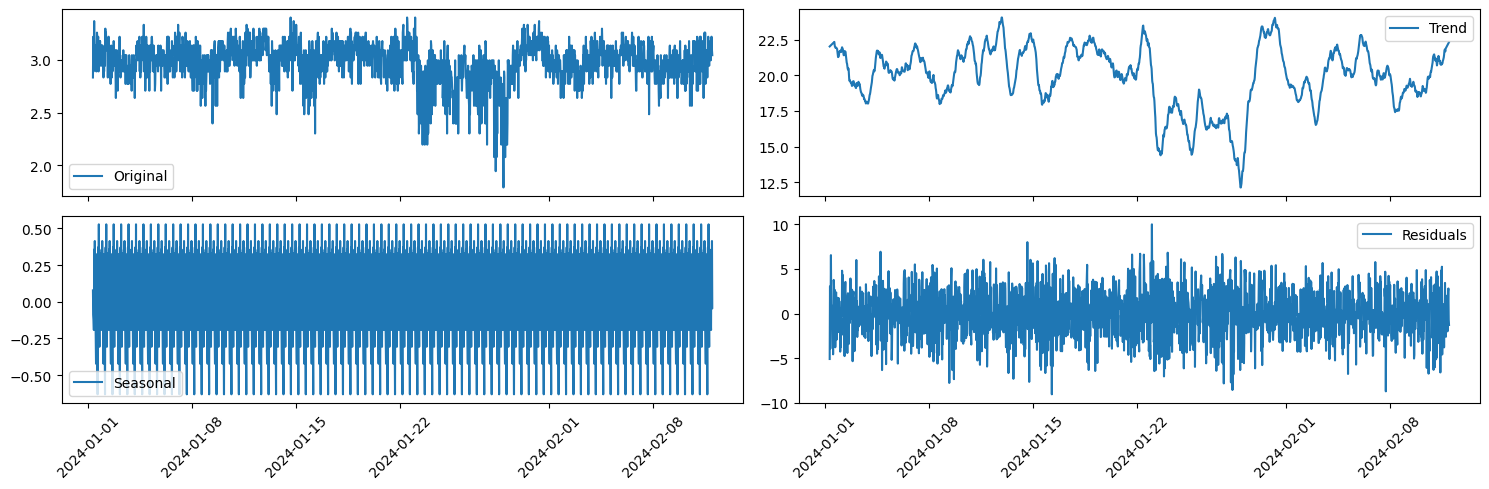

In [ ]:
plot_decomposition(new_df,people_count='people_count_log' , trend='trend' , seasonal = 'seasonal' , residual='residuals')

# DICKEY-FULLER

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(new_df['residuals'],autolag='AIC')

In [ ]:
def test_stationarity(t_df, people_count):

  rolmean = t_df[people_count].rolling(window=12, center= False).mean()
  rolstd =  t_df[people_count].rolling(window=12, center = False).std()

  orig = plt.plot(t_df[people_count], color = 'blue', label ="Original")
  mean = plt.plot(rolmean, color ='red', label ="Rolling Mean")
  std = plt.plot(rolstd, color='black', label ="Rolling Std")
  plt.legend(loc = 'best')
  plt.title("Rolling Mean and Standard Deviation for  %s" %(people_count))
  plt.xticks(rotation =45)
  plt.show(block = False)
  plt.close

  print('Results:')
  dftest = adfuller(t_df[people_count], autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=["Test Statistic",'p=value','# Lasgs Used',' Number of Observations'])

  for key, value in dftest[4].items():
    dfoutput['Critical Value(%s)' %key]= value

  print(dfoutput)

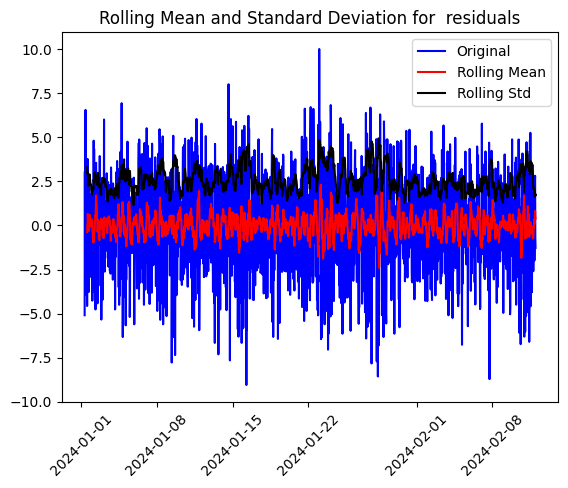

Results:
Test Statistic            -1.469902e+01
p=value                    2.966891e-27
# Lasgs Used               2.400000e+01
 Number of Observations    1.975000e+03
Critical Value(1%)        -3.433665e+00
Critical Value(5%)        -2.863005e+00
Critical Value(10%)       -2.567550e+00
dtype: float64


In [ ]:
test_stationarity(new_df,'residuals')

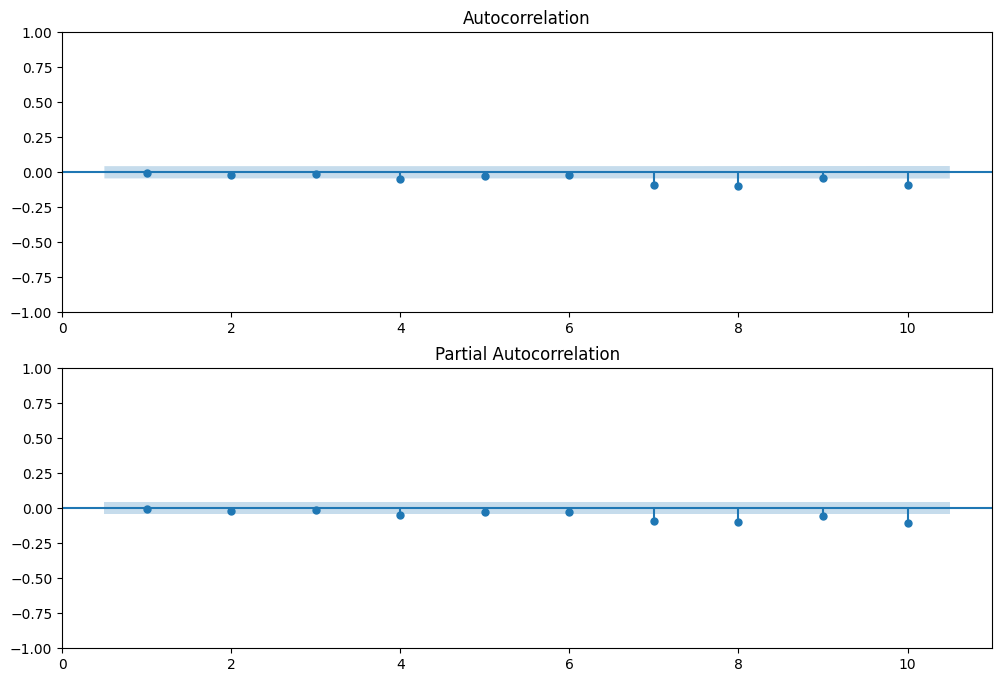

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF of df
plot_acf(new_df['residuals'], lags=10, zero=False, ax=ax1);

# Plot the PACF of df
plot_pacf(new_df['residuals'], lags=10, zero=False, ax=ax2);

In [ ]:
new_df = new_df.fillna(value=0)

# Comapring Between ARIMA and SARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def run_ARIMA(t_df,people_count,p,d,q):
  model = ARIMA(t_df[people_count] , order=(p,d,q))
  results_arima = model.fit()

  len_results = len(results_arima.fittedvalues)
  ts_modified = t_df[people_count][-len_results:]

  rss  = sum((results_arima.fittedvalues-ts_modified)**2)
  rmse = np.sqrt(rss/len(t_df[people_count]))
  print('RMSA: ', rmse)

  plt.figure()
  plt.plot(t_df[people_count])
  plt.plot(results_arima.fittedvalues,color='red')
  plt.show()

  return results_arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)


RMSA:  2.5656226483093696


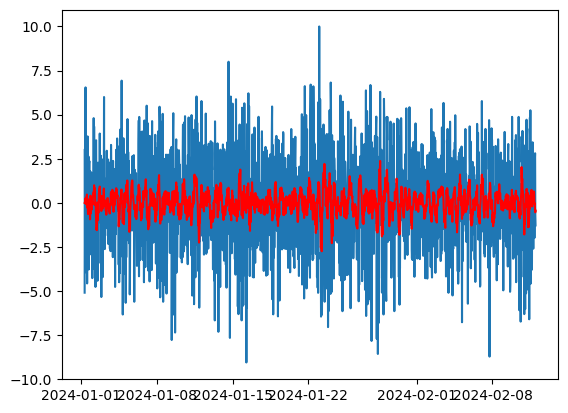

In [ ]:
model_AR = run_ARIMA(t_df=new_df,people_count='residuals',p=15,d=0,q=0)

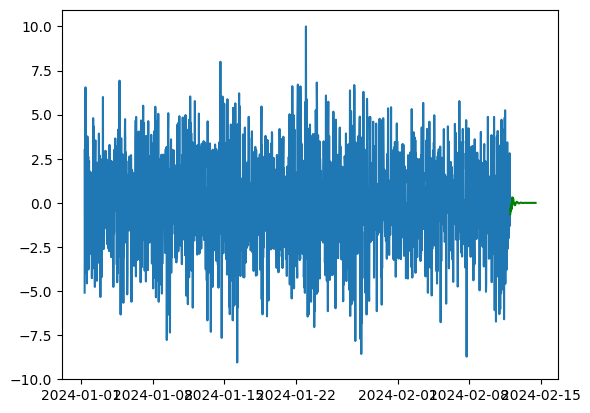

In [ ]:
my_forecast = model_AR.forecast(120) # Hours
plt.figure()
plt.plot(new_df['residuals'])
plt.plot(my_forecast,color='green')


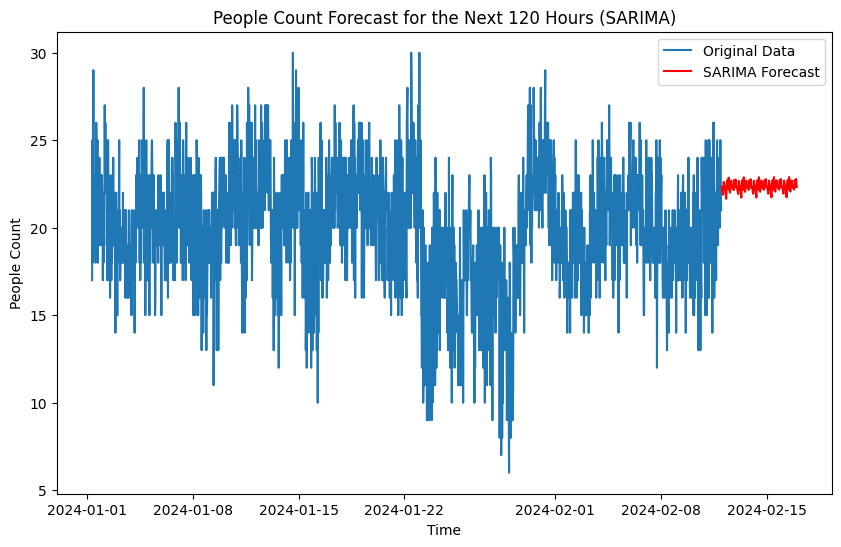

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Fit the SARIMA model
sarima_model = SARIMAX(t_df['people_count'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_fit = sarima_model.fit()

# Forecast the next  hours
n_hours = 120  # Set hours
forecast_sarima = sarima_fit.forecast(steps=n_hours)

# Create a time index for the forecast
forecast_index = pd.date_range(t_df.index[-1], periods=n_hours + 1, freq='h')[1:]

# Plot the original data and SARIMA forecast
plt.figure(figsize=(10,6))
plt.plot(t_df.index, t_df['people_count'], label='Original Data')  # Original data
plt.plot(forecast_index, forecast_sarima, color='red', label='SARIMA Forecast')  # SARIMA forecast
plt.legend()
plt.title(f'People Count Forecast for the Next {n_hours} Hours (SARIMA)')
plt.xlabel('Time')
plt.ylabel('People Count')
plt.show()


**HAND OVER TO MODEL DEVELOPER**

In [25]:
!jupyter nbconvert --to html /content/NNN_FINAL_OB_TS.ipynb


[NbConvertApp] Converting notebook /content/NNN_FINAL_OB_TS.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 28 image(s).
[NbConvertApp] Writing 7945613 bytes to /content/NNN_FINAL_OB_TS.html
